# Neural Style Transfer

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. It merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S.

For example, let’s take an image of this turtle and Katsushika Hokusai's *The Great Wave off Kanagawa*:

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1560278258/example.jpg">

Style transfer is an interesting technique that showcases the capabilities and internal representations of neural networks.  

In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as kr
import tensorflow as tf
import numpy as np
from IPython import display
from PIL import Image
from tensorflow.keras.optimizers import Adam

### Let's upload our style and transfer images:

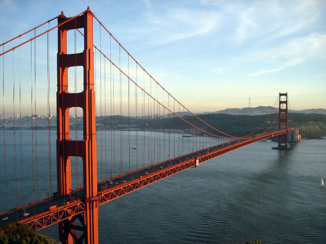

In [2]:
from PIL import Image
content = Image.open('/content/drive/MyDrive/content1.jpg')
style = Image.open('/content/drive/MyDrive/style1.jpg')
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 400


new_size = (content.width // 3, content.height // 3)  # Reduce the size to half
content_resized = content.resize(new_size)
style_resized = style.resize(new_size)
content_resized

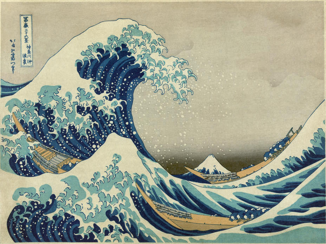

In [3]:
style_resized

### Let's take pixels of our images and reshape them:

In [4]:
#take pixels for content
content_np = np.array(content)
tensor_content = tf.convert_to_tensor(content_np)
reshape = tf.image.resize(tensor_content, size=(IMAGE_HEIGHT, IMAGE_WIDTH))
content_pixels = tf.expand_dims(reshape, axis=0)


#take pixels for style
style_np = np.array(style)
tensor_style = tf.convert_to_tensor(style_np)
reshape = tf.image.resize(tensor_style, size=(IMAGE_HEIGHT, IMAGE_WIDTH))
style_pixels = tf.expand_dims(reshape, axis=0)

##Preprocess

We will use VGG19 model using Transfer learning. VGG networks(and other ImageNet models) are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68] and with channels BGR.

In [5]:
C = kr.applications.vgg19.preprocess_input(content_pixels)
S = kr.applications.vgg19.preprocess_input(style_pixels)

Let's see now how looks like our image:

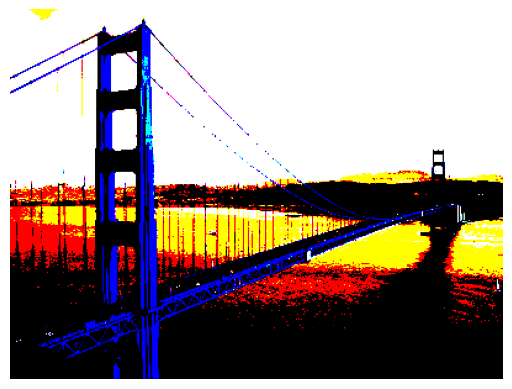

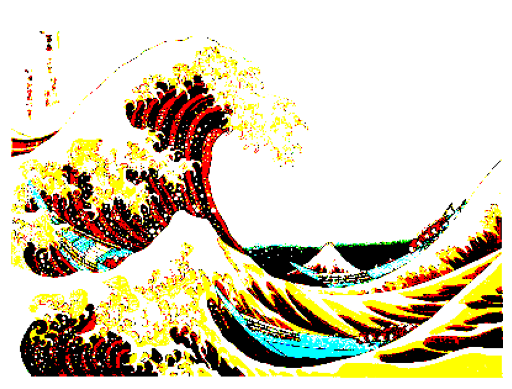

In [6]:
tensor_image = tf.squeeze(C, axis=0)
plt.imshow(tensor_image.numpy())
plt.axis('off')
plt.show()


tensor_image = tf.squeeze(S, axis=0)
plt.imshow(tensor_image.numpy())
plt.axis('off')
plt.show()

Now I will deprocess this image, and we will see how it will look like.

In [10]:
def deprocess_img(processed_img):
    #x = processed_img.numpy()
    x = processed_img
    if not isinstance(x, np.ndarray):
      x = x.numpy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert back to RGB from BGR

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
dep_S = deprocess_img(C)
dep_C = deprocess_img(S)

array([[[125, 152, 182],
        [126, 153, 183],
        [126, 153, 183],
        ...,
        [173, 192, 199],
        [171, 189, 198],
        [168, 188, 199]],

       [[126, 155, 185],
        [128, 157, 187],
        [129, 158, 188],
        ...,
        [173, 191, 201],
        [171, 189, 199],
        [165, 185, 196]],

       [[126, 157, 186],
        [129, 160, 189],
        [132, 162, 191],
        ...,
        [173, 192, 202],
        [170, 190, 200],
        [165, 186, 199]],

       ...,

       [[  4,  15,  16],
        [  1,   8,  10],
        [  3,   8,   8],
        ...,
        [ 29,  44,  49],
        [ 31,  46,  51],
        [ 33,  48,  55]],

       [[  0,   9,   9],
        [  0,   8,   9],
        [  0,   6,  10],
        ...,
        [ 25,  38,  44],
        [ 30,  43,  49],
        [ 32,  45,  53]],

       [[  0,   7,   2],
        [  0,   7,   8],
        [  0,   4,   9],
        ...,
        [ 31,  44,  50],
        [ 27,  40,  46],
        [ 22,  35,  43]]], dtype=uint8)
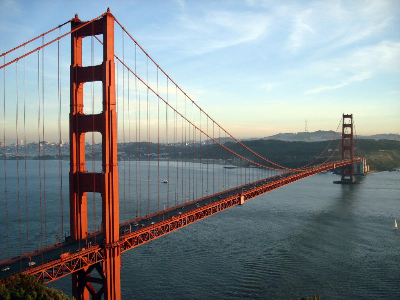

In [12]:
dep_S

array([[[237, 227, 191],
        [240, 230, 194],
        [236, 227, 188],
        ...,
        [228, 219, 180],
        [226, 216, 180],
        [221, 211, 176]],

       [[239, 229, 193],
        [240, 230, 194],
        [239, 229, 193],
        ...,
        [220, 210, 174],
        [227, 217, 181],
        [232, 222, 186]],

       [[240, 230, 192],
        [216, 206, 171],
        [207, 197, 164],
        ...,
        [217, 207, 172],
        [228, 219, 180],
        [223, 214, 174]],

       ...,

       [[196, 193, 161],
        [198, 194, 159],
        [211, 203, 167],
        ...,
        [108, 141, 126],
        [102, 145, 136],
        [125, 147, 127]],

       [[187, 184, 152],
        [199, 195, 160],
        [207, 199, 163],
        ...,
        [102, 135, 120],
        [ 93, 136, 127],
        [118, 140, 121]],

       [[199, 196, 166],
        [221, 216, 184],
        [206, 197, 164],
        ...,
        [184, 187, 160],
        [186, 189, 162],
        [190, 193, 166]]], dtype=uint8)
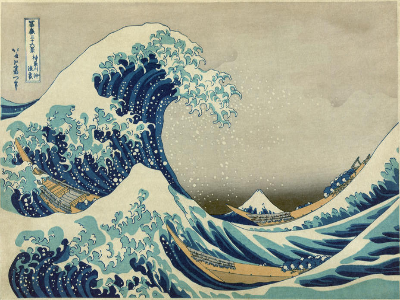

In [13]:
dep_C

### Let's define our model vgg19:

In [14]:
_vgg = kr.applications.vgg19.VGG19(include_top=False,
                                   weights=None,
                                   input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
_vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 100, 128)      0     

We will use the intermediate layers of the model to get the content and style representations of the image.

**Why intermediate layers?**

At a high level, in order for a network to perform image classification, it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features. These intermediate layers are necessary to define the representation of content and style from the images. The model serves as a complex feature extractor; hence by accessing intermediate layers, we’re able to describe the content and style of input images.

We would like the "generated" image G to have similar content as the input image C. Suppose we have chosen some layer's activations to represent the content of an image. We'll get the most visually pleasing results if we choose a layer in the middle of the network--neither too shallow nor too deep.

In [15]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']

# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

## Build the Model

Let's create a function that will take an input image and output the result of content and style intermediate layers

In [16]:
def get_model(styles, contents):
    """ Creates our model with access to intermediate layers.
    Loads the VGG19 model and access the intermediate layers.
    These layers will then be used to create a new model that will take input image
    and return the outputs from these intermediate layers from the VGG model.

    Parameters:
    -----------
    styles: list
        A list containing all style layers from VGG19 model
    contents: list
        A list containing all content layers from VGG19 model

    Returns:
    --------
    VGG: kr.Model
        A keras model that takes image inputs and outputs the style and
        content intermediate layers.
    """

    vgg = kr.applications.vgg19.VGG19(include_top=False,
                                      weights='imagenet',
                                      input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    vgg.trainable = False

    # Get output layers corresponding to style and content layers
    style_outputs = [vgg.get_layer(layer_name).output for layer_name in styles]
    content_outputs = [vgg.get_layer(layer_name).output for layer_name in contents]
    model_outputs = style_outputs + content_outputs

    return kr.Model(vgg.input, model_outputs)

### Content Loss

Our content loss function is actually quite simple. We will try to measure how much is the G(Generated image) and C(Content image) are similar to each other. Now, we will set the image C as the input to the pretrained VGG network, and run forward propagation. $a^{(C)}$ will be the hidden layer activations in the layer we had chosen. This will be a 3D Tensor with the shape of [H, W, C]. Then we'll repeat this process with the image G as well. Therefore $a^{(G)}$ will be the corresponding hidden layer activation. We then can define as the content loss function as:

$$L_{content}(C,G) = \sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

In [17]:
def get_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

## Style Loss

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. We will calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations.

After generating the Style matrix (Gram matrix), we will minimize the distance between the Gram matrix of the image S and image G. For now, we can derive the loss using only a single hidden layer $a^{[l]}$, and the corresponding style loss for this layer is defined as:

$$L_{style}^{[l]}(S,G) = \sum_{i,j}(Gram^{(S)}_{ij} - Gram^{(G)}_{ij})^2 $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the style image and the generated image, computed using the hidden layer activations for a particular hidden layer in the network.

It turns out that you get more visually pleasing results if you use the style loss function from multiple different layers. So, the overall style cost function, we can define as:

$$L_{style}(S,G) = \sum_{l} \lambda^{[l]} L^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`.


In [18]:
def get_layer_style_loss(style, generated):
    def gram_matrix(tensor):
        channels = int(tensor.shape[-1])
        a = tf.reshape(tensor, [-1, channels])
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / tf.cast(tf.shape(a)[0], tf.float32)

    gram_style = gram_matrix(style)
    gram_generated = gram_matrix(generated)
    return tf.reduce_mean(tf.square(gram_style - gram_generated))


def get_style_loss(style, generated):
    loss = 0
    coeffs = [0.2, 0.2, 0.2, 0.2, 0.2]
    for s, g, coeff in zip(style, generated, coeffs):
        loss += coeff * get_layer_style_loss(s, g)

    return loss

## Total loss:

This is where we will combine style and content losses together.

$$L(G) = \alpha L_{content}(C,G) + \beta L_{style}(S,G)$$

In [34]:
def compute_loss(model, image, style_features, content_features, alpha=0.01, beta=0.002):
    """This function will compute the loss total loss.

    Parameters:
    -----------
    model: kr.Model
        The model that will give us access to the intermediate layers
    image: Tensor
        Initial image. This is what we are updating with the optimization process.
    style_features: Tensor
        Precomputed style features from our Style image.
    content_features: Tensor
        Precomputed content features from our Content image.

    Returns:
    loss: Tensor
        Returns the total loss
    """

    # Feed our init image through our model.
    model_outputs = model(image)

    content_generated = [content_layer[0] for content_layer in model_outputs[len(style_layers):]][0]
    style_generated = [style_layer for style_layer in model_outputs[:len(style_layers)]]

    content_loss = alpha * get_content_loss(content_features, content_generated)
    style_loss = beta * get_style_loss(style_features, style_generated)

    # Get total loss
    loss = style_loss + content_loss
    return loss

### Gradient Tape

For gradients we have two main parts: **Compute Gradients** and **Apply Gradients**

**Compute Gradients**: This is where tensorflow helps us the most by calculating the derivaties between the output and input according to our loss function.

**Apply Gradients**: After the gradients were calculated, optimize calls this function to apply gradients to trainable variables. It this case we will update the **generated image** as trainable parameter.

In [35]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        loss = compute_loss(**cfg)
    # Compute gradients with respect to input image
    return tape.gradient(loss, cfg['image']), loss

## Apply Style Transfer to Images

In [36]:
def transfer_style(C, S, epochs=1000):
    def generate_noisy_image(content_image, noise_ratio):
        """Generates a noisy image by adding random noise to the content image"""

        noise_image = tf.random.uniform([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3], minval=-20, maxval=20)
        input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
        return input_image

    # We don't want to train any layers of our model
    model = get_model(style_layers, content_layers)
    for layer in model.layers:
        layer.trainable = False



    style_outputs = model(S)
    content_outputs = model(C)

    # Get the style and content feature representations (from our specified intermediate layers)
    _content = [content_layer[0] for content_layer in content_outputs[len(style_layers):]][0]
    _style = [style_layer[0] for style_layer in style_outputs[:len(style_layers)]]

    # Set initial image
    G = generate_noisy_image(C, 0.001)
    #G = tf.contrib.eager.Variable(G, dtype=tf.float32)
    G = tf.Variable(G, dtype=tf.float32)
    best_loss, best_img = float('inf'), None

    # Create a nice config
    cfg = {
        'model': model,
        'image': G,
        'style_features': _style,
        'content_features': _content
    }

    # Create our optimizer
    opt = Adam(learning_rate=2, beta_1=0.99, epsilon=1e-1)

    # For displaying
    display_interval = epochs/(2*5)

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(epochs):
        grads, cost = compute_grads(cfg)
        opt.apply_gradients([(grads, G)])
        clipped = tf.clip_by_value(G, min_vals, max_vals)
        G.assign(clipped)

        if cost < best_loss:
            best_loss = cost
            best_img = deprocess_img(G.numpy())

        if i % display_interval== 0:
            plot_img = G.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            display.clear_output(wait=True)
            display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}, LOSS: {:.4e}'.format(i, cost))


    display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

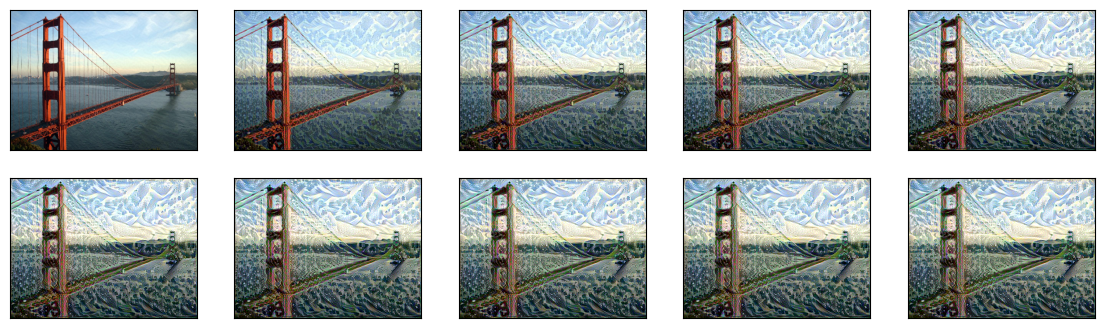

In [37]:
best, best_loss = transfer_style(C, S, epochs=200)

array([[[139, 163, 158],
        [155, 166, 162],
        [143, 148, 154],
        ...,
        [138, 156, 164],
        [132, 155, 139],
        [100, 141, 127]],

       [[145, 151, 145],
        [161, 154, 148],
        [184, 161, 156],
        ...,
        [182, 163, 171],
        [150, 151, 132],
        [113, 142, 116]],

       [[123, 132, 139],
        [158, 146, 142],
        [216, 155, 125],
        ...,
        [186, 165, 156],
        [147, 112, 106],
        [110, 147, 130]],

       ...,

       [[  1,  46,   0],
        [  7,  59,   1],
        [  0,  41,   0],
        ...,
        [  0,  17,   1],
        [  0,  37,  24],
        [  0,  39,  45]],

       [[  9,  56,   8],
        [ 59,  71,  35],
        [ 42,  73,   0],
        ...,
        [ 30,  64,  43],
        [ 28,  67,  61],
        [ 18,  60,  63]],

       [[  0,   0,   0],
        [  0,  26,   0],
        [  0,   9,   0],
        ...,
        [ 36,  77,  51],
        [ 26,  67,  54],
        [  0,  26,  29]]], dtype=uint8)
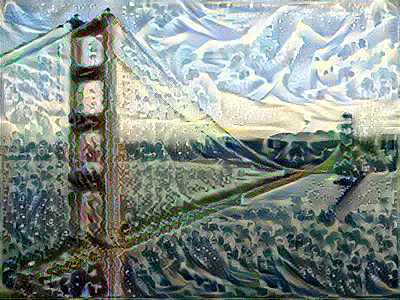

In [38]:
best